<h5>Data Analysis</h5>

In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re #import regular expressions module (set of string that matches the criteria)
from collections import defaultdict
import us #import us library
fda_1 = pd.read_csv("clean_fda_data.csv")
#conn = sqlite3.connect("clean_fda_data.db")
fda_1.to_sql("clean_fda_data", conn, if_exists="replace", index=False)

4582

In [37]:
#fda_1.nunique()

In [38]:
#inspecting data using Python
#fda_1.head()

<Axes: title={'center': 'Top Recall Causes'}, ylabel='Reason Category'>

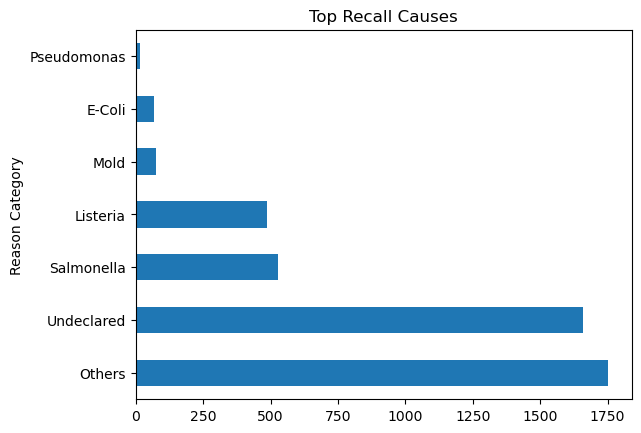

In [14]:
fda_1["Reason Category"].value_counts().plot(kind='barh', title='Top Recall Causes')

<Axes: title={'center': 'Recall by Class'}, xlabel='Reason Category'>

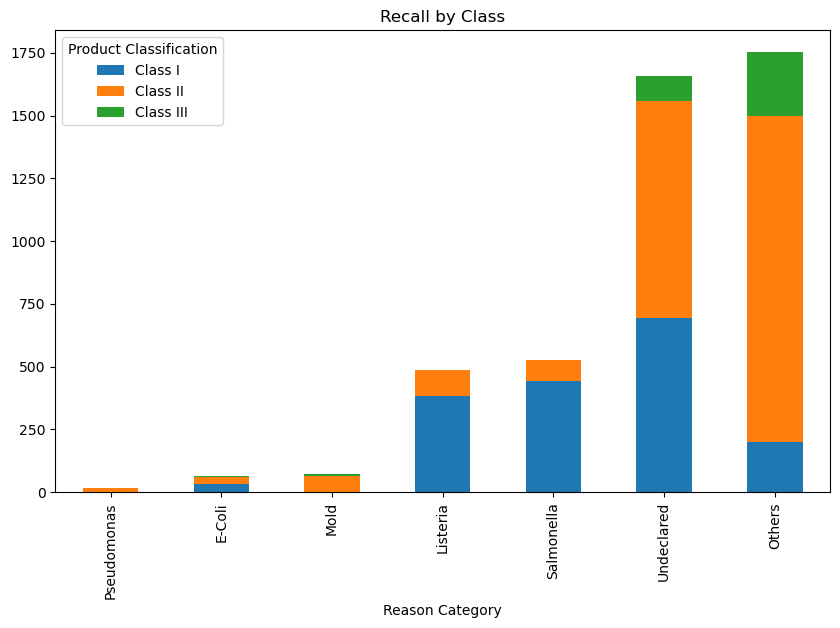

In [15]:
class_group = fda_1.groupby(["Reason Category", "Product Classification"]).size().unstack().fillna(0)
class_group = class_group.loc[class_group.sum(axis=1).sort_values(ascending=True).index]
class_group.plot(kind='bar', stacked=True, figsize=(10,6), title="Recall by Class")

In [29]:
#Create a mapping of state abbreviations and names and store it in a dictionary as state name
state_lookup = {}
for state in us.states.STATES:
    state_lookup[state.abbr.upper()] = state.name
    state_lookup[state.name.upper()] = state.name

#Function to extract unique, standardized state names from a string
def extract_states(text):
    found_states = set()
    if pd.isnull(text):
        return found_states
    text_upper = text.upper()
    for key, full_name in state_lookup.items():
        if re.search(r'\b' + re.escape(key) + r'\b', text_upper):
            found_states.add(full_name)
    return found_states

#Apply function to extract states per row
fda_1["Name_States"] = fda_1["Distribution Pattern"].apply(extract_states)

#Build a dictionary mapping Reason Category
category_to_states = defaultdict(set)
for _, row in fda_1.iterrows():
    reason = row["Reason Category"]
    states = row["Name_States"]
    category_to_states[reason].update(states)

#Convert the result into a dataframe
reason_state_fda_1 = pd.DataFrame({
    "Reason Category": list(category_to_states.keys()),
    "Total States Impacted": [len(states) for states in category_to_states.values()]
}).sort_values(by="Total States Impacted", ascending=False).reset_index(drop=True)

display(reason_state_fda_1.head())

,Reason Category,Total States Impacted
0,Undeclared,50
1,Listeria,50
2,Others,50
3,Salmonella,50
4,Mold,50


In [12]:
#Count each state once per row even if both abbreviation and full name appear
#Count either abbreviation or full name, not both, only one per state per row
#Sum that up across all rows for each state

#create dictionary of state abbreviations and full names
states = {state.abbr: state.name for state in us.states.STATES}

#Store in count number
state_counts = defaultdict(int)

#loop through each state abbreviation and full name
for pattern in df["Distribution Pattern"].dropna():
    for abbr, full in states.items():
        if (re.search(r'\b' + abbr + r'\b', pattern, flags = re.IGNORECASE) or
             re.search(r'\b' + full + r'\b', pattern, flags = re.IGNORECASE)):
              state_counts[full] += 1

#Get a count of how many rows mention each state
#Print output line by line, more clean
for full, count in sorted(state_counts.items()):
    print(f"{full}: {count}")

Alabama: 3637
Alaska: 772
Arizona: 4548
Arkansas: 3178
California: 7455
Colorado: 4133
Connecticut: 4267
Delaware: 2259
Florida: 7010
Georgia: 5560
Hawaii: 1282
Idaho: 2079
Illinois: 7233
Indiana: 11629
Iowa: 3666
Kansas: 3181
Kentucky: 4511
Louisiana: 3458
Maine: 2558
Maryland: 4990
Massachusetts: 4735
Michigan: 6162
Minnesota: 4528
Mississippi: 2951
Missouri: 5120
Montana: 2070
Nebraska: 2626
Nevada: 3378
New Hampshire: 2783
New Jersey: 5874
New Mexico: 2106
New York: 8009
North Carolina: 6053
North Dakota: 1700
Ohio: 7476
Oklahoma: 3184
Oregon: 4862
Pennsylvania: 7569
Rhode Island: 1883
South Carolina: 4343
South Dakota: 1434
Tennessee: 4631
Texas: 6711
Utah: 2464
Vermont: 1138
Virginia: 6401
Washington: 4918
West Virginia: 1959
Wisconsin: 5570
Wyoming: 2083


In [39]:
#fda_1["Center Classification Date"].dtype

In [30]:
#Parse month and year from center classification date
#fda_1["Center Classification Date"] = pd.to_datetime(fda_1["Center Classification Date"], errors = 'coerce')

#Extract year and month
fda_1["Year"] = fda_1["Center Classification Date"].dt.year
fda_1["Month"] = fda_1["Center Classification Date"].dt.month

In [32]:
#Create a new dataframe with exploded states
fda_expand = fda_1.explode("Name_States").copy()

#Group data by year, month, reason category, and state
event_summary = fda_expand.groupby(
    ["Year", "Month", "Reason Category", "Name_States"]
).size().reset_index(name="Number of Events")

#Rename columns
event_summary.rename(columns={"Name_States": "State"}, inplace = True)
display(event_summary.head())

,Year,Month,Reason Category,State,Number of Events
0,2012,6,Others,Alabama,1
1,2012,6,Others,Arizona,2
2,2012,6,Others,California,9
3,2012,6,Others,Colorado,1
4,2012,6,Others,Connecticut,1
